# How convolutional neural networks see the world

Inspired by [Keras blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)

[OpenAI blog post](https://blog.openai.com/adversarial-example-research/)

[CleverHans](http://www.cleverhans.io/)

[Morning Paper blog post](https://blog.acolyer.org/2017/02/28/when-dnns-go-wrong-adversarial-examples-and-what-we-can-learn-from-them/)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

## Define the VGG16 model in Keras

In [2]:
from keras import applications
from keras import backend as K

Using TensorFlow backend.


The imported model is already initialized with the weights from the ImageNet competition submission in 2014.

The top layers are removed as:
 * they are at an abstraction level specific to the problem;
 * their definition prevents the Convolutional layers from working with any input size.

In [3]:
model = applications.VGG16(include_top=False, weights='imagenet')

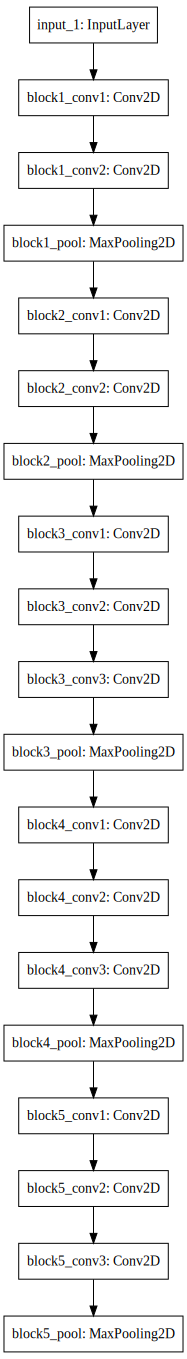

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

## 1<sup>st</sup> Task: What activates each layer's convolutional filters

### Set-up some needed configurations

Number of random filters selected per layer

In [7]:
nr_filters_per_layer = 3

The layers in which we will investigate the filters

In [8]:
layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

In [9]:
filter_indexes = [
    np.random.choice(range(layer_dict[layer_name].output.shape[3].value), nr_filters_per_layer)
    for layer_name in layer_names
]

### Prepare an input image with random noise

Neural network's input image placeholder

In [10]:
input_img = model.input

Function to generate an image with random noise

In [11]:
def generate_random_image(img_width=128, img_height=128):
    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    return input_img_data

Utilitary function to convert a tensor into a valid image

In [12]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Visualize a generated image

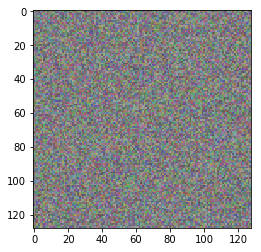

In [13]:
plt.imshow(deprocess_image(generate_random_image()[0]))

### Define optimization objective

In [14]:
layer_nr = 4
filter_nr = 2

Neural network's placeholder for layer's tensor

In [15]:
layer_output = layer_dict[layer_names[layer_nr]].output

Define the "loss" as being the average value of the desired filter in the selected layer

In [16]:
if K.image_data_format() == 'channels_first':
    loss = K.mean(layer_output[:, filter_nr, :, :])
else:
    loss = K.mean(layer_output[:, :, :, filter_nr])

Compute the gradient of the input picture with respoct to this loss, *i.e.* the direction in which we can vary the input image in order to increase or decrease the "loss"

In [17]:
grads = K.gradients(loss, input_img)[0]

Normalize the gradients

In [18]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [19]:
grads = normalize(grads)

Function that returns the loss and gradients given the input picture

In [20]:
iterate = K.function([input_img], [loss, grads])

For a given number of iterations, modify the input image so we increase the activation at the desired filter:

In [21]:
input_img_data = generate_random_image()

In [22]:
step = 1.

In [23]:
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

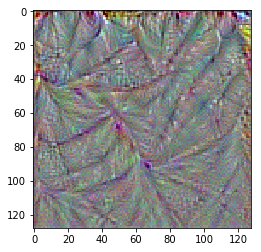

In [24]:
plt.imshow(deprocess_image(input_img_data[0]))

<img src="https://blog.keras.io/img/vgg16_filters_overview.jpg">

## Finding an input that maximizes a specific class

In [25]:
model = applications.VGG16(include_top=True,
                           weights='imagenet')

553410560/553467096 [============================>.] - ETA: 0s

In [26]:
input_img = model.input

[ImageNet Labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

#### What is the NN understanding of a Sea Snake?

In [27]:
output_index = 65 # sea snake
loss = K.mean(model.output[:, output_index])

In [28]:
grads = K.gradients(loss, input_img)[0]

In [29]:
grads = normalize(grads)

In [30]:
iterate = K.function([input_img], [loss, grads])

In [31]:
input_img_data = generate_random_image(224, 224)

In [32]:
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    if i == 20:
        deprocess_image(input_img_data[0])
    print(loss_value)

0.000368968
0.000372644
0.000376382
0.000380233
0.000384242
0.000388351
0.000392483
0.000396702
0.000401002
0.00040539
0.000409925
0.000414593
0.000419303
0.000424142
0.000429095
0.000434049
0.000439121
0.000444448
0.000449873
0.00045543
0.000461005
0.00166988
0.00294188
0.00651813
0.0127814
0.0342733
0.100694
0.274675
0.260026
0.606356
0.726001
0.536677
0.855644
0.986351
0.995637
0.996758
0.997246
0.997579
0.99783
0.998023


In [33]:
print(loss_value)

0.998023


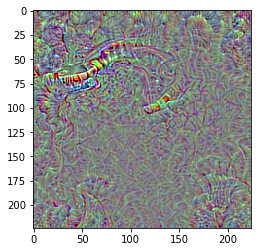

In [34]:
plt.imshow(deprocess_image(input_img_data[0]))

## Real Image

In [36]:
from PIL import Image
import requests
from io import BytesIO

In [38]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg'

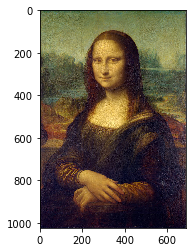

In [75]:
response = requests.get(url)
mona_lisa_img = Image.open(BytesIO(response.content))
plt.imshow(mona_lisa_img)

In [76]:
img_width = 224
img_height = 224

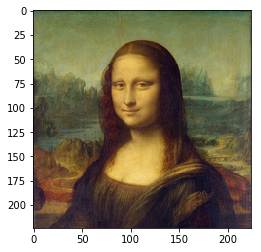

In [77]:
mona_lisa_img.thumbnail((img_width, 500), Image.ANTIALIAS)
mona_lisa_img = mona_lisa_img.crop((0, 0, img_width, img_height))

In [94]:
mona_lisa_img_data = np.array(mona_lisa_img).astype(np.float32) / 256.
# numpy uses channels last, so we need only to change if channels_first in backend
if K.image_data_format() == 'channels_first':
    mona_lisa_img_data = mona_lisa_img_data.transpose(2, 0, 1)
mona_lisa_img_data = mona_lisa_img_data.reshape((1,) + mona_lisa_img_data.shape)

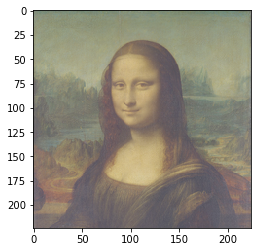

In [95]:
plt.imshow(deprocess_image(mona_lisa_img_data[0]))

In [96]:
for i in range(20):
    loss_value, grads_value = iterate([mona_lisa_img_data])
    mona_lisa_img_data += grads_value * 0.01
    print(loss_value)

0.00111387
0.00160289
0.0022107
0.00291447
0.00373409
0.00488478
0.00651235
0.00962121
0.0143367
0.0196884
0.030424
0.0469675
0.0672089
0.0941191
0.126506
0.165377
0.204978
0.244473
0.284565
0.326303


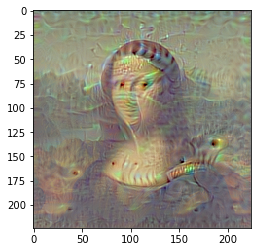

In [97]:
plt.imshow(deprocess_image(mona_lisa_img_data[0]))

In [98]:
for i in range(20):
    loss_value, grads_value = iterate([mona_lisa_img_data])
    mona_lisa_img_data += grads_value * 0.01
    print(loss_value)

0.322345
0.3671
0.388534
0.462602
0.47626
0.537812
0.557499
0.627018
0.643657
0.693208
0.709627
0.753097
0.755215
0.808676
0.820955
0.849988
0.854466
0.876246
0.878336
0.894805


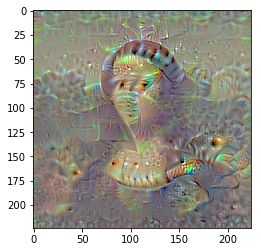

In [99]:
plt.imshow(deprocess_image(mona_lisa_img_data[0]))

In [100]:
for i in range(20):
    loss_value, grads_value = iterate([mona_lisa_img_data])
    mona_lisa_img_data += grads_value * 0.01
    print(loss_value)

0.840428
0.85764
0.857023
0.88881
0.882144
0.907057
0.905281
0.920861
0.921561
0.933205
0.934238
0.942156
0.944007
0.950254
0.951873
0.957512
0.957598
0.962136
0.962868
0.966674


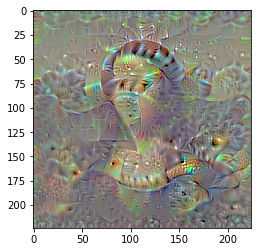

In [101]:
plt.imshow(deprocess_image(mona_lisa_img_data[0]))

In [102]:
for i in range(20):
    loss_value, grads_value = iterate([mona_lisa_img_data])
    mona_lisa_img_data += grads_value * 0.01
    print(loss_value)

0.941028
0.945448
0.946556
0.955055
0.956248
0.961251
0.960049
0.965925
0.965838
0.969991
0.970538
0.973712
0.974177
0.976268
0.976589
0.978144
0.978255
0.980178
0.980789
0.98183


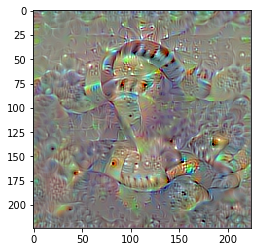

In [103]:
plt.imshow(deprocess_image(mona_lisa_img_data[0]))